In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

# Creating Spark session
spark = SparkSession.builder.appName("SteamGamesSuccess").getOrCreate()

data = "games_march2025_full.csv"
df = spark.read.csv("games_march2025_full.csv", header=True, inferSchema=True)
df.show(truncate=False)



+-------+-------------------------------+------------+------------+-----+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
used_columns = [
    "appid", "name", "release_date", "genres", "tags", "developers", "publishers",
    "price", "discount", "recommendations", "positive", "negative", "peak_ccu", "dlc_count"
]

df1 = df.select(*used_columns)

df1.show(20)

+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+--------+---------------+--------+--------+--------+---------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount|recommendations|positive|negative|peak_ccu|dlc_count|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+--------+---------------+--------+--------+--------+---------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|           ['Valve']|    0|       0|        4401572| 7480813| 1135108| 1212356|        1|
| 578080| PUBG: BATTLEGROUNDS|  21/12/2017|['Action', 'Adven...|{'Survival': 1483...|['PUBG Corporation']|   ['KRAFTON, Inc.']|    0|       0|        1732007| 1487960| 1024436|  616738|        0|
|    570|           

In [3]:
df1 = df1.withColumnRenamed("discount", "discount_percentage")

In [4]:
df1 = df1.withColumnRenamed("peak_ccu", "peak_playernum")

In [5]:
df1.printSchema()

root
 |-- appid: string (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- developers: string (nullable = true)
 |-- publishers: string (nullable = true)
 |-- price: string (nullable = true)
 |-- discount_percentage: string (nullable = true)
 |-- recommendations: string (nullable = true)
 |-- positive: string (nullable = true)
 |-- negative: string (nullable = true)
 |-- peak_playernum: string (nullable = true)
 |-- dlc_count: string (nullable = true)



In [6]:
print(f"Total Records: {df1.count()}")

df1.show()

Total Records: 94954
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|           ['Valve']|    0|                  0|        4401572| 7480813| 1135108|       1212356|        1|
| 578080| PUBG: BATTLEGROUNDS|  21/12/2017|['Action', 'Adven...|{'Survival': 1483...|['PUBG Corporation']|   ['KRAFTON, Inc.']|

# Data Preprocessing
- Handling Missing Values

In [7]:
from pyspark.sql.functions import col, sum

null_counts = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
null_counts.show()

+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+
|appid|name|release_date|genres|tags|developers|publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+
|    0|   2|           0|     5|  10|         9|         9|    0|                 11|             10|     110|      75|             9|        0|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+



In [8]:
# We dropped null name rows, because a game without a name is invalid.
# We dropped null tag rows, because there were quite a few of them and we do not get much out of them.
# We dropped null peak_playernum rows, because if it has had no peak it means it it does not have a playerbase, so we do not need it.
df_cleaned = df1.dropna(subset=["name", "tags", "peak_playernum"])

# We changed null genres into "unknown", because there were only two of them. It won't impact the analyzis much.
df_filled = df_cleaned.fillna({"genres": "unknown", "developers": "unknown", "publishers": "unknown", "discount_percentage": "0", "recommendations": "0"
                               ,"positive": "0", "negative": "0"})




In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, regexp_replace, trim, when, round

In [10]:
df = df_filled.withColumn(
    "positive_clean",
    when(
        trim(col("positive")).rlike("^\d+$"),
        trim(col("positive")).cast("double")
    ).otherwise(0)
).withColumn(
    "negative_clean",
    when(
        trim(col("negative")).rlike("^\d+$"),
        trim(col("negative")).cast("double")
    ).otherwise(0)
).withColumn(
    "all_reviews",
    round(col("positive_clean") + col("negative_clean"), 2)
)


In [11]:
#creating the percentage of reviews columns
df_with_percentages = df.withColumn(
    "positive_percentage", 
    (F.col("positive") / F.col("all_reviews") * 100).cast("double")
).withColumn(
    "negative_percentage", 
    (F.col("negative") / F.col("all_reviews") * 100).cast("double")
)

df_with_percentages = df_with_percentages.withColumn(
    "positive_percentage", 
    F.round(F.col("positive_percentage"), 2)
).withColumn(
    "negative_percentage", 
    F.round(F.col("negative_percentage"), 2)
)

df_with_percentages.show()


+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|         

In [12]:
df = df_with_percentages.fillna({"positive_percentage": "0", "negative_percentage": "0"})

In [13]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|appid|name|release_date|genres|tags|developers|publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    0|   0|           0|     0|   0|         0|         0|    0|                  0|              0|       0|       0|             0|        0|             0|             0|          0|                  0|                  0|
+-----+----+------------+------+----+----------+----------+-----+-------------------+-------

In [14]:
df.show()

+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|         

**Duplicates**

In [15]:
id_duplicates = df.groupBy("appid").count().filter("count > 1")
name_duplicates = df.groupBy("name").count().filter("count > 1")

id_duplicates.show()
name_duplicates.show()

+--------------------+-----+
|               appid|count|
+--------------------+-----+
|nd deciding the s...|    2|
|   ahead of schedule|    2|
+--------------------+-----+

+--------------------+-----+
|                name|count|
+--------------------+-----+
|              ISLAND|    2|
|Romance of the Th...|    2|
|            Downfall|    2|
|      Eternal Return|    2|
|Ys I & II Chronic...|    2|
|               Chasm|    2|
|               Nomad|    2|
|Loading Screen Si...|    2|
|      Hero's Journey|    3|
|The Lord of the R...|    2|
|             Journey|    2|
|Call of Duty®: Bl...|    2|
|        Blood Strike|    2|
|Call of Duty®: Bl...|    2|
|          The Bunker|    3|
|    EA SPORTS FC™ 24|    4|
|              WASTED|    2|
|         Battle Ball|    2|
|            Paradise|    2|
|       Haunted House|    2|
+--------------------+-----+
only showing top 20 rows



In [16]:
df_no_duplicates = df.dropDuplicates(["name"])

name_duplicates = df_no_duplicates.groupBy("name").count().filter("count > 1")
name_duplicates.show()

+----+-----+
|name|count|
+----+-----+
+----+-----+



In [17]:
used_columns = [
    "appid", "name", "release_date", "genres", "tags", "developers", "publishers",
    "price", "discount_percentage", "recommendations", "peak_playernum", "dlc_count", "all_reviews", "positive_percentage", "negative_percentage"
]

df_final = df_no_duplicates.select(*used_columns)

In [18]:
df_final.show(10)

+-------+------------------------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------------+---------+-----------+-------------------+-------------------+
|  appid|                                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|peak_playernum|dlc_count|all_reviews|positive_percentage|negative_percentage|
+-------+------------------------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------------+---------+-----------+-------------------+-------------------+
| 406760|                 "FL337 - ""Fleet"""|  20/06/2017|['Action', 'Adven...|"{'Action': 21, '...| ['KWL Productions']| ['KWL Productions']| 4.99|                  0|              0|             0|        0| 

MongoDB

In [19]:
# Convert Spark DataFrame to Pandas
pandas_df = df_final.toPandas()

# Convert to list of MongoDB-ready docs
records = pandas_df.to_dict(orient="records")

# Make appid the _id (so it's the primary key)
for doc in records:
    doc["_id"] = doc["appid"]  # Use appid as the _id

# Connect to MongoDB
from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
db = client["steam_games_db"]
collection = db["games_cleaned"]

# Drop old collection if it exists
collection.drop()

collection.insert_many(records)

print(f"Inserted {len(records)} docs")


Inserted 94178 docs


In [20]:
# Fetch all documents from the "games_cleaned" collection, excluding the "_id" field
games_docs = list(db["games_cleaned"].find({}, {"_id": 0}))  # Excluding "_id" field

# Convert the list of documents into a Spark DataFrame
df_games = spark.createDataFrame(games_docs)

# Ensure _id is at the beginning, followed by the other columns
columns = ['appid'] + [col for col in df_games.columns if col != 'appid']

# Reorder the DataFrame columns
df_games = df_games.select(*columns)

# Show the first 3 rows to inspect the order of the columns
df_games.show(3)

+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+-------------------+---------------+------------+--------------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|         publishers|recommendations|release_date|                tags|
+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+-------------------+---------------+------------+--------------------+
| 406760|        3.0| ['KWL Productions']|                  0|        0|['Action', 'Adven...|                 "FL337 - ""Fleet"""|              33.33|             0|              66.67| 4.99|['KWL Productions']|   

# Spark optimization


In [21]:
# Cache the DataFrame if it will be used multiple times
df_games.cache()


DataFrame[appid: string, all_reviews: double, developers: string, discount_percentage: string, dlc_count: string, genres: string, name: string, negative_percentage: double, peak_playernum: string, positive_percentage: double, price: string, publishers: string, recommendations: string, release_date: string, tags: string]

In [22]:
# Show the execution plan to check optimizations
df_games.explain(True)


== Parsed Logical Plan ==
'Project ['appid, 'all_reviews, 'developers, 'discount_percentage, 'dlc_count, 'genres, 'name, 'negative_percentage, 'peak_playernum, 'positive_percentage, 'price, 'publishers, 'recommendations, 'release_date, 'tags]
+- LogicalRDD [all_reviews#7653, appid#7654, developers#7655, discount_percentage#7656, dlc_count#7657, genres#7658, name#7659, negative_percentage#7660, peak_playernum#7661, positive_percentage#7662, price#7663, publishers#7664, recommendations#7665, release_date#7666, tags#7667], false

== Analyzed Logical Plan ==
appid: string, all_reviews: double, developers: string, discount_percentage: string, dlc_count: string, genres: string, name: string, negative_percentage: double, peak_playernum: string, positive_percentage: double, price: string, publishers: string, recommendations: string, release_date: string, tags: string
Project [appid#7654, all_reviews#7653, developers#7655, discount_percentage#7656, dlc_count#7657, genres#7658, name#7659, negati

In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

# Define a UDF to classify games based on positive_percentage and recommendations
def classify_success(positive_percentage, recommendations):
    try:
        recommendations_int = int(recommendations)  # Convert recommendations to an integer
    except ValueError:
        recommendations_int = 0  # Default to 0 if conversion fails

    # Define conditions for classification
    if positive_percentage > 80 and recommendations_int > 1000:
        return "Successful"
    elif positive_percentage > 50 and recommendations_int > 100:
        return "Moderate"
    else:
        return "Unsuccessful"

# Register the UDF
classify_success_udf = udf(classify_success, StringType())

# Apply the UDF to add a new column 'success_category' based on the classification
games_with_success_classification = df_games.withColumn(
    "success_category", 
    classify_success_udf(col("positive_percentage"), col("recommendations"))
)

# Show the resulting DataFrame with the new 'success_category' column
games_with_success_classification.show()


+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
| 406760|        3.0| ['KWL Productions']|                  0|        0|['Action', 'Adven...|                 "FL337 - ""Fleet"""|              33.33|          

In [24]:
games_with_success_classification.createOrReplaceTempView("games")

In [25]:
spark.sql("SELECT * FROM games").show(10)

+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
| 406760|        3.0| ['KWL Productions']|                  0|        0|['Action', 'Adven...|                 "FL337 - ""Fleet"""|              33.33|          

In [26]:
spark.sql("SELECT * FROM games WHERE success_category NOT LIKE 'Unsuccessful'").show()

+-------+-----------+--------------------+-------------------+---------+--------------------+--------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+--------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
| 525480|     3793.0|   ['CyberConnect2']|                  0|        0|             ['RPG']|.hack//G.U. Last ...|              13.13|            60|              86.87|49.99|['Bandai Namco En...|           3

In [27]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

#Filter out rows with 'Unsuccessful' success_category
filtered_df = games_with_success_classification.filter(F.col("success_category") != "Unsuccessful")

## Comparing the overall success of the games in 2025

In [28]:
#Categorize prices
categorized_df = filtered_df.withColumn(
    "price_category",
    F.when(F.col("price") == 0, "Free")
     .when(F.col("price") < 10, "Budget")
     .when(F.col("price") < 30, "Mid-range")
     .otherwise("Premium")
)

In [29]:
success_order = F.when(F.col("success_category") == "Successful", 3) \
                 .when(F.col("success_category") == "Moderate", 2) \
                 .when(F.col("success_category") == "Unsuccessful", 1) \
                 .otherwise(0)


In [73]:
import time
# numeric rank column
categorized_df = categorized_df.withColumn("success_rank", success_order)

# Window ordered by success_rank descending
price_window = Window.partitionBy("price_category").orderBy(F.desc("success_rank"))

start_time = time.time()
# Apply ranking
price_analysis = categorized_df.withColumn("rank_in_category", F.rank().over(price_window))
price_analysis.select("appid","name", "price", "price_category", "success_category", "success_rank", "rank_in_category").show(truncate=False)
print(f"Window function execution time: {time.time() - start_time:.2f} seconds")


+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|appid  |name                                          |price|price_category|success_category|success_rank|rank_in_category|
+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|282800 |100% Orange Juice                             |6.99 |Budget        |Successful      |3           |1               |
|1424660|9-nine-:Episode 4                             |9.99 |Budget        |Successful      |3           |1               |
|397270 |A Kiss For The Petals - Remembering How We Met|7.99 |Budget        |Successful      |3           |1               |
|948740 |AI: The Somnium Files                         |7.99 |Budget        |Successful      |3           |1               |
|317250 |Airscape - The Fall of Gravity                |4.99 |Budget        |Successful      |3           |1               |


In [74]:
success_categories = ["Successful", "Moderate", "Unsuccessful"]
counts = []
start_time = time.time()
for category in success_categories:
    count = games_with_success_classification.filter(
        col("success_category") == category
    ).count()

    print(f"{category}: {count} games")
    counts.append(count)

print(f"Count execution time: {time.time() - start_time:.2f} seconds")

Successful: 3585 games
Moderate: 11455 games
Unsuccessful: 79138 games
Count execution time: 28.38 seconds


In [32]:
best_games = price_analysis.filter(F.col("rank_in_category") != "3")
best_games.select("appid", "name", "price", "price_category", "success_category", "success_rank", "rank_in_category").show(truncate=False)

+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|appid  |name                                          |price|price_category|success_category|success_rank|rank_in_category|
+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|282800 |100% Orange Juice                             |6.99 |Budget        |Successful      |3           |1               |
|1424660|9-nine-:Episode 4                             |9.99 |Budget        |Successful      |3           |1               |
|397270 |A Kiss For The Petals - Remembering How We Met|7.99 |Budget        |Successful      |3           |1               |
|948740 |AI: The Somnium Files                         |7.99 |Budget        |Successful      |3           |1               |
|317250 |Airscape - The Fall of Gravity                |4.99 |Budget        |Successful      |3           |1               |


In [33]:
best_games_pandas = best_games.select(
    "appid", "name", "price", "price_category", "success_category", "success_rank", "rank_in_category"
).toPandas()

# Convert the Pandas DataFrame to a list of dictionaries
records = best_games_pandas.to_dict(orient="records")

In [35]:
# Make appid the _id (so it's the primary key)
for doc in records:
    doc["_id"] = doc["appid"]  # Use appid as the _id
    
# Insert the records into the 'successful_games' collection
collection = db["successful_games"]  # Define the collection name
collection.insert_many(records)  # Insert the list of dictionaries into MongoDB

BulkWriteError: batch op errors occurred, full error: {'writeErrors': [{'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: steam_games_db.successful_games index: _id_ dup key: { _id: "282800" }', 'keyPattern': {'_id': 1}, 'keyValue': {'_id': '282800'}, 'op': {'appid': '282800', 'name': '100% Orange Juice', 'price': '6.99', 'price_category': 'Budget', 'success_category': 'Successful', 'success_rank': 3, 'rank_in_category': 1, '_id': '282800'}}], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 0, 'nModified': 0, 'nRemoved': 0, 'upserted': []}

In [36]:
best_games.count()

15040

Importing the collection back for visualization purposes

In [76]:

from pyspark.sql.functions import explode, split, regexp_replace, col
start_time = time.time()
# Step 1: Filter Successful and Moderate Games
best_games = price_analysis.filter(F.col("rank_in_category") != "3")

# Step 2: Exploding toilets
df_exploded_tags = best_games.withColumn(
    "tag", 
    explode(split(regexp_replace("tags", "[\\[\\]' ]", ""), ","))
)

# Step 3: Clean the tag by removing numbers after the colon
df_exploded_tags_clean = df_exploded_tags.withColumn(
    "clean_tag", 
    split(col("tag"), ":").getItem(0)  # Keeps only the first part (before the colon)
)
# Step 4: Count tags for successful games
df_successful = df_exploded_tags_clean.filter(col("success_category") == "Successful") \
    .groupBy("clean_tag").count().withColumnRenamed("count", "successful_count")

# Step 5: Count tags for moderate games
df_moderate = df_exploded_tags_clean.filter(col("success_category") == "Moderate") \
    .groupBy("clean_tag").count().withColumnRenamed("count", "moderate_count")

# Step 6: Perform a join on clean_tag to compare counts between successful and moderate games
df_joined = df_successful.join(
    df_moderate,
    on="clean_tag",  # Joining on the tag name
    how="outer"  # Outer join to include tags from both categories
)

# Step 7: Order the results based on the successful_count (highest successful_count first)
df_joined_ordered = df_joined.orderBy("successful_count", ascending=False)  # Order by successful_count, highest first

# Step 8: Show the results ordered by the successful count of tags
df_joined_ordered.show(10, truncate=False)

print(f"Count execution time: {time.time() - start_time:.2f} seconds")

+---------------+----------------+--------------+
|clean_tag      |successful_count|moderate_count|
+---------------+----------------+--------------+
|Singleplayer   |2758            |7050          |
|Adventure      |1725            |4217          |
|Indie          |1674            |5353          |
|Action         |1552            |3627          |
|Atmospheric    |1228            |2694          |
|StoryRich      |1211            |2631          |
|2D             |1098            |3201          |
|Multiplayer    |1058            |2099          |
|Casual         |982             |3286          |
|GreatSoundtrack|932             |1229          |
+---------------+----------------+--------------+
only showing top 10 rows

Count execution time: 38.49 seconds


In [43]:
# Convert the Spark DataFrame to a Pandas DataFrame
most_used_tags_df = df_joined_ordered.toPandas()

# Convert to a list of MongoDB-ready documents (JSON-like format)
records = most_used_tags_df.to_dict(orient="records")

# Insert the data into the 'most_used_tags' collection
collection = db["most_used_tags"]  # Using the already established connection

# Drop the existing collection if it exists (to avoid duplicates)
collection.drop()

# Insert the data into the collection
collection.insert_many(records)

print(f"Inserted {len(records)} documents into 'most_used_tags' collection.")


Inserted 964 documents into 'most_used_tags' collection.


Importing the collection back for visualization purposes

In [44]:
# Fetch the data from the 'most_used_tags' collection in MongoDB
most_used_tags_docs = list(db["most_used_tags"].find())

# Convert the documents to a Pandas DataFrame
most_used_tags_df = pd.DataFrame(most_used_tags_docs)

# Display the DataFrame for visualization
print(most_used_tags_df.head())  # Shows the first few rows for visualization


                        _id     clean_tag  successful_count  moderate_count
0  67f63b5273b1117a2fcb8a46  Singleplayer            2758.0          7050.0
1  67f63b5273b1117a2fcb8a47     Adventure            1725.0          4217.0
2  67f63b5273b1117a2fcb8a48         Indie            1674.0          5353.0
3  67f63b5273b1117a2fcb8a49        Action            1552.0          3627.0
4  67f63b5273b1117a2fcb8a4a   Atmospheric            1228.0          2694.0


# Visualization

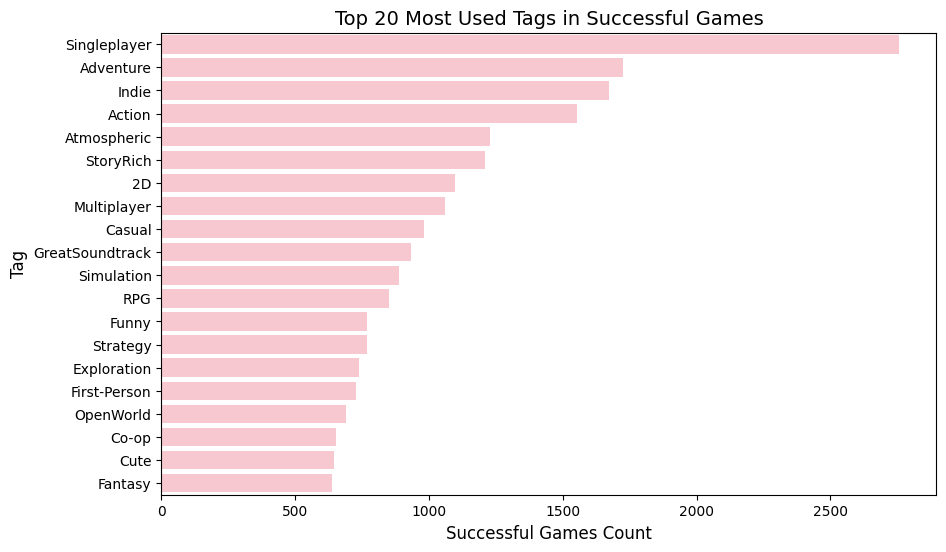

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame based on successful_count for better visualization
most_used_tags_df = most_used_tags_df.sort_values(by="successful_count", ascending=False)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot using Seaborn
sns.barplot(x="successful_count", y="clean_tag", data=most_used_tags_df.head(20), color="pink")  # Top 20 most used tags

# Set plot labels and title
plt.title("Top 20 Most Used Tags in Successful Games", fontsize=14)
plt.xlabel("Successful Games Count", fontsize=12)
plt.ylabel("Tag", fontsize=12)

# Show the plot
plt.show()


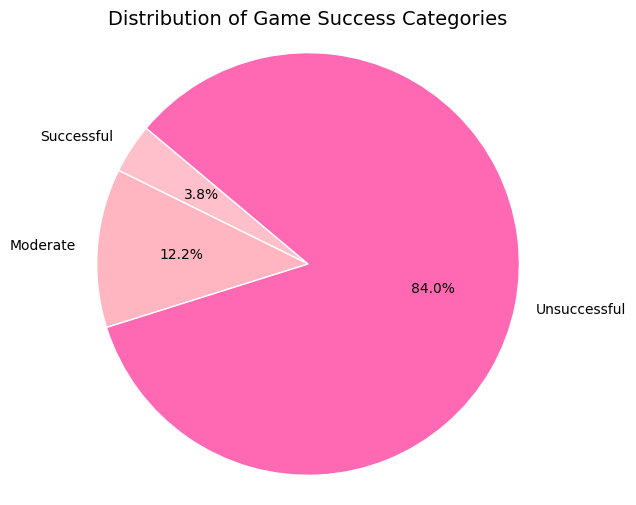

In [75]:
plt.figure(figsize=(6, 6))
colors = ["#FFC0CB", "#FFB6C1", "#FF69B4"]  # Pastel pink tones
plt.pie(
    counts,
    labels=success_categories,
    colors=colors,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Distribution of Game Success Categories", fontsize=14)
plt.axis("equal")  # Equal aspect ratio for circle shape
plt.show()

In [ ]:
import pandas as pd

# Query the 'successful_games' collection from MongoDB
successful_games_data = collection.find({}, {"_id": 0})  # Exclude _id

# Convert the MongoDB documents to a Pandas DataFrame
successful_games_df = pd.DataFrame(list(successful_games_data))

# Show the first few rows of the DataFrame
print(successful_games_df.head())

# Now you can use 'successful_games_df' for your visualization process


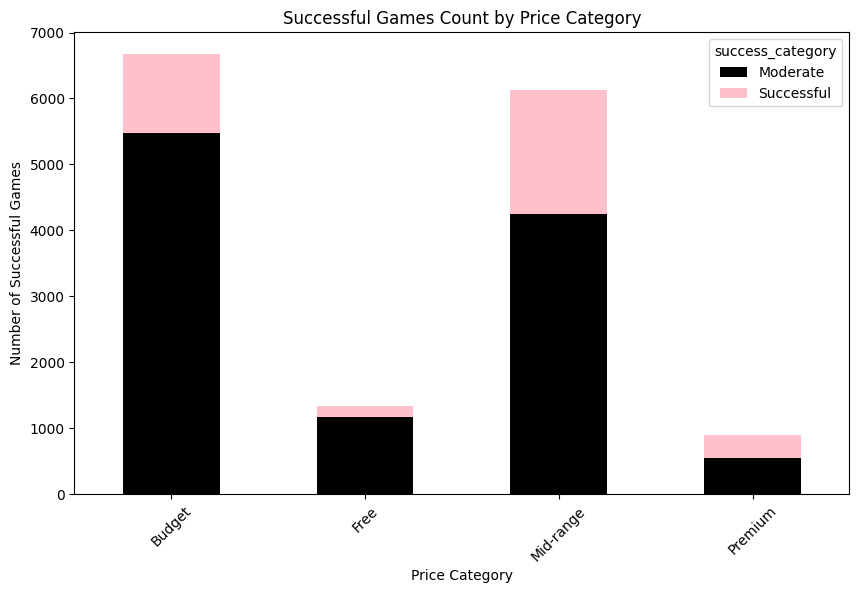

In [60]:
# Count of successful games by price category
success_by_price = successful_games_df.groupby('price_category')['success_category'].value_counts().unstack().fillna(0)

# Plot the count of successful games by price category
success_by_price.plot(kind='bar', stacked=True, color=['black', 'pink'], figsize=(10, 6))
plt.title('Successful Games Count by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Successful Games')
plt.xticks(rotation=45)
plt.show()

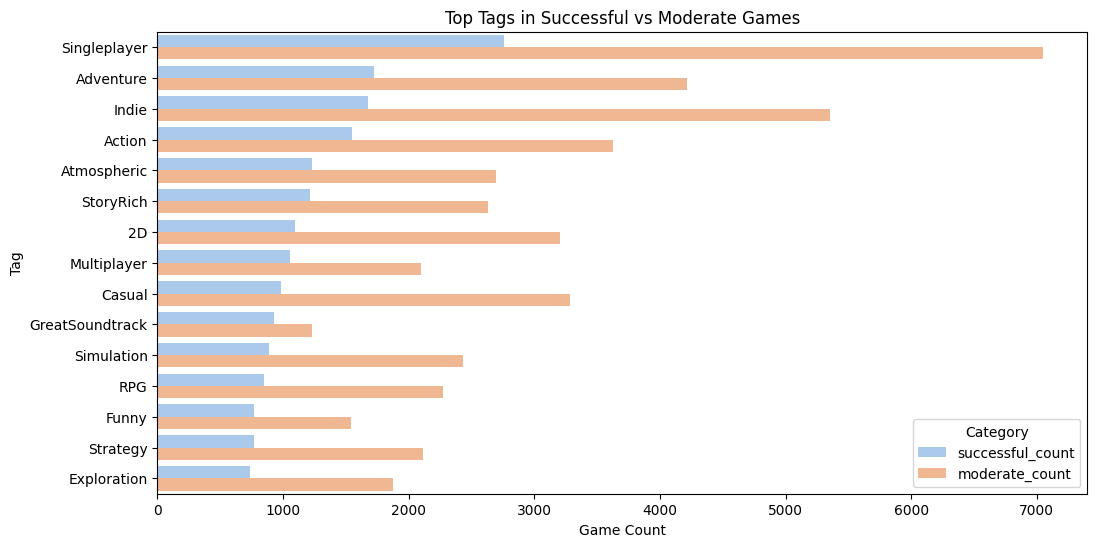

In [68]:
# Take top N most common tags
top_tags = most_used_tags_df.sort_values(by='successful_count', ascending=False).head(15)

# Melt the dataframe to long format
melted_tags = top_tags.melt(id_vars="clean_tag", value_vars=["successful_count", "moderate_count"], 
                            var_name="Category", value_name="Count")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_tags, x="Count", y="clean_tag", hue="Category", palette="pastel")
plt.title("Top Tags in Successful vs Moderate Games")
plt.xlabel("Game Count")
plt.ylabel("Tag")
plt.show()
